# Imports

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
# general array and data handling
import numpy as np
import pandas as pd

# tensor operations and neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LeakyReLU

# Ploting
import matplotlib.pyplot as plt
%matplotlib inline

# Data Loading

In [3]:
#for use in google colaboratory
#!git clone https://github.com/shusunny/GAN-stock-entry.git

Cloning into 'GAN-stock-entry'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 35 (delta 4), reused 27 (delta 2), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [4]:
data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]
data_name = data_names[0]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path)

GAN-stock-entry/datasets/GOOG.csv


In [5]:
dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,1089.420897,1100.046811,1079.321435,1090.083688,1090.083688,1.671534e+06
std,268.589405,272.693779,265.381490,269.099996,269.099996,7.686312e+05
min,667.849976,672.299988,663.059998,668.260010,668.260010,3.468000e+05
25%,835.755005,841.975006,831.254975,836.994995,836.994995,1.209400e+06
50%,1083.560059,1094.244995,1072.204956,1082.760010,1082.760010,1.466700e+06
75%,1229.390015,1241.369995,1219.445007,1230.540039,1230.540039,1.889050e+06
max,1824.520020,1847.199951,1822.650024,1827.989990,1827.989990,6.348100e+06


In [6]:
dataframe.shape

(1259, 7)

In [7]:
def add_Entry(dataframe):
  for i in range(0,dataframe.shape[0]):
    dataframe.loc[dataframe.index[i],'Entry'] = np.round((dataframe.iloc[i,3]+ (dataframe.iloc[i,2] -dataframe.iloc[i,3])*0.2),5)
  return dataframe

dataframe=add_Entry(dataframe)
dataframe.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Entry
0,2016-01-04,743.000000,744.059998,731.257996,741.840027,741.840027,3272800,733.81840
1,2016-01-05,746.450012,752.000000,738.640015,742.580017,742.580017,1950700,741.31201
2,2016-01-06,730.000000,747.179993,728.919983,743.619995,743.619995,1947000,732.57198
3,2016-01-07,730.309998,738.500000,719.059998,726.390015,726.390015,2963700,722.94800
4,2016-01-08,731.450012,733.229980,713.000000,714.469971,714.469971,2450900,717.04600


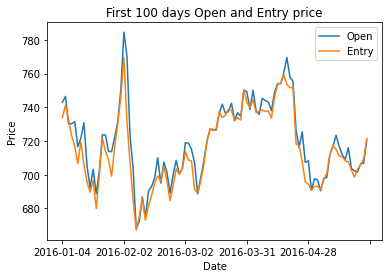

In [8]:
ax = plt.gca()
dataframe.iloc[0:100].plot(x='Date',y='Open',ax=ax)
dataframe.iloc[0:100].plot(x='Date',y='Entry', ax=ax)

plt.title("First 100 days Open and Entry price")
plt.ylabel("Price")
plt.show()

# Preprocessing

In [9]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    # shape : (n_batch, n_sequence, n_features)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    std[std==0] = 1
    samples = (samples - mean[:,None,:])/std[:,None,:] #standarize along each feature
    targets = (targets - mean[:,6:7])/std[:,6:7] # The entry value is our target
    return samples, targets

In [10]:
# TimeseriesGenerator Check

data = np.array([[i, i**2,i**3,i**4] for i in range(11)])
targets = np.array([[i**4] for i in range(11)])

print(targets.shape)

mean = data[:-1].mean(axis=0)[None,:]
std = data[:-1].std(axis=0)[None,:]

data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=10, sampling_rate=1,
                               batch_size=2)
batch_0 = data_gen[0]
x, y = batch_0

print(np.array(x*std+mean,dtype = np.int))
print(y*std[..., 3]+mean[..., 3])

(11, 1)
[[[   0    0    0    0]
  [   1    1    1    1]
  [   2    4    8   16]
  [   3    9   27   81]
  [   4   16   64  256]
  [   5   25  125  625]
  [   6   36  216 1296]
  [   7   49  343 2401]
  [   8   64  512 4096]
  [   9   81  729 6561]]]
[]


In [11]:
data.shape

(11, 4)

In [12]:
n_sequence = 5
n_batch = 128
n_features = 7

def get_gen_train_test(dataframe):
  data = dataframe.drop(columns='Date').to_numpy()
  targets = data[:,3, None] #add none to have same number of dimensions as data
  #targets = data
  n_samples = data.shape[0]

  train_test_split=int(n_samples*0.9)

  data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
  data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)
  
  return data_gen_train, data_gen_test

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

In [13]:
data_gen_train[0]

(array([[[ 0.25283549, -1.00561555, -0.35698875, ..., -0.95371353,
          -0.99201777, -0.50700563],
         [ 1.44548196,  0.48168856,  0.29166722, ...,  1.44222269,
           0.31488896,  0.34653406],
         [ 0.49931417, -0.12283807,  1.1280658 , ..., -0.28913611,
          -0.95787589,  0.94473809],
         [-0.79669897, -1.00561555, -1.74591817, ..., -1.0761469 ,
          -0.094254  , -1.70033668],
         [-1.40093263,  1.65238061,  0.68317389, ...,  0.87677385,
           1.7292587 ,  0.91607017]],
 
        [[-0.55597634,  0.72576638, -0.12542283, ...,  1.42957534,
           1.49001738,  0.08830374],
         [ 1.59654197,  1.43876028,  1.95091516, ...,  0.34967776,
          -0.65988705,  1.87949831],
         [-0.66866891, -1.45963487, -0.74870932, ..., -1.40106485,
          -0.66911828, -0.95323799],
         [-1.08752263, -0.46258636, -0.67605537, ...,  0.4431811 ,
          -1.05099961, -0.64210739],
         [ 0.71562592, -0.24230543, -0.40072763, ..., -0.8213

In [14]:
# test on data

x_gen, y_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=1)[0]
print(x_gen)
print(y_gen)

x = data[None, :5,:]
mean = x.mean(axis=1)
std = x.std(axis=1)
x = (x - mean)/std
y = (data[5,3] - mean[...,3])/std[...,3]
print(x)
print(y)

assert (x_gen == x).all()
assert (y_gen == y).all()

[[[-1.41421356 -1.01709526 -0.83189033 -0.72799757]
  [-0.70710678 -0.84757938 -0.79029581 -0.71771512]
  [ 0.         -0.33903175 -0.4991342  -0.56347834]
  [ 0.70710678  0.50854763  0.29116162  0.10488101]
  [ 1.41421356  1.69515876  1.83015873  1.90431003]]]
[]
[[[-1.41421356 -1.01709526 -0.83189033 -0.72799757]
  [-0.70710678 -0.84757938 -0.79029581 -0.71771512]
  [ 0.         -0.33903175 -0.4991342  -0.56347834]
  [ 0.70710678  0.50854763  0.29116162  0.10488101]
  [ 1.41421356  1.69515876  1.83015873  1.90431003]]]
[5.69853465]


# Baseline 

In [15]:
# baseline: use previous day as estimation for the next
squared_error = 0
def mean_squared_error(X, lenght = 5):
  squared_error = 0
  for i in range(0, X.shape[0] - lenght):
    x = X[i:i+lenght]
    mean = x.mean()
    std = x.std()
    x = (x - mean)/std
    y = (X[i+lenght] - mean)/std
    squared_error += np.square(x[-1]-y)
  return squared_error/X.shape[0]

baseline_error = mean_squared_error(data[:,3])
baseline_error

3.4528189810500125

In [16]:
data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=32)

# baseline: use previous day as estimation for the next
def mean_squared_error(dataset):
  mse=0
  for X_batch, y_batch in dataset:
    # X_batch.shape : (n_batch, n_sequence, n_features)
    #mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch))
    mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch))
  mse /= len(dataset)
  return mse

baseline_error = mean_squared_error(data_gen)
baseline_error 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

# Utilities

In [17]:
# Metrics not included in keras

# For some reason keras mape is different so it has to be customly defined.
# Paper definition isn't percentual, hence the difference. (x100)
def mse(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true-y_pred))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true-y_pred)))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true-y_pred)/y_true))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:] > y_true[:-1],tf.float32)
    return tf.reduce_mean((y_true[1:]-y_true[:-1])*mask)


# LSTM

In [18]:
def make_LSTM_model():

  inputs = Input(shape=(n_sequence, n_features,))

  lstm_1 = LSTM(units=10, return_sequences = True, activation=None, kernel_initializer='random_normal')(inputs)
  batch_norm1=tf.keras.layers.BatchNormalization()(lstm_1)
  lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
  lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
  lstm_2 = LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_1_droput)
  batch_norm2=tf.keras.layers.BatchNormalization()(lstm_2)
  lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
  lstm_2_droput = Dropout(0.3)(lstm_2_LRelu)
  #lstm_3 = LSTM(units=10, return_sequences = True, activation=None)(lstm_2_droput)
  #batch_norm3=tf.keras.layers.BatchNormalization()(lstm_3)
  #lstm_3_LRelu = LeakyReLU(alpha=0.3)(batch_norm3) 
  #lstm_3_droput = Dropout(0.3)(lstm_3_LRelu)
  #lstm_4 = LSTM(units=100, return_sequences = False, activation=None)(lstm_3_droput)
  #batch_norm4=tf.keras.layers.BatchNormalization()(lstm_4)
  #lstm_4_LRelu = LeakyReLU(alpha=0.3)(batch_norm4) 
  #lstm_4_droput = Dropout(0.5)(lstm_4_LRelu)
  output_dense = Dense(1, activation=None)(lstm_2_droput)
  output = LeakyReLU(alpha=0.3)(output_dense) 


  model = Model(inputs = inputs, outputs = output)
  model.compile(loss='mse', metrics = [mse , mae, mape, rmse, ar])
  model.summary()

  #return model, slice_model
  return model

# Visualization

In [19]:
metrics = ["loss", 'mse','mae','mape','rmse','ar']
def plot_history(history):
  #metrics = ["loss", 'mse','mae','mape','rmse','ar']
  #metrics = ["gen_loss","gen_slice_loss", 'mse','mae','mape','rmae','ar']
  for metric_name in metrics:  
    plt.figure()
    plt.title(metric_name)
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.plot(history.history[metric_name], label='train')
    plt.plot(history.history["val_"+metric_name], label='test')
    plt.legend()
  plt.show()

#plot_history(history)

In [20]:
def plot_frame(sequence, target, model):
  sequence, target = data_gen_test[0]
  y_pred = model.predict(sequence)
  y_true = target

  plt.figure()
  plt.title("Entry price errors")
  plt.xlabel('Test samples')
  plt.ylabel("Errors")
  plt.plot(y_true, label="true")
  plt.plot(y_pred, label="prediction")
  plt.legend()
  plt.show()

#plot_frame(*data_gen_test[0], lstm)

# Test on all datasets

In [21]:
results = np.zeros((5,6))
EPOCHS = 500

### Google Stock

GAN-stock-entry/datasets/GOOG.csv
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 10)             720       
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 10)             0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_1 (Batc

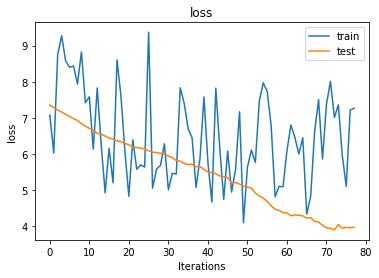

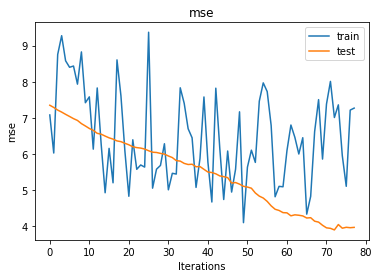

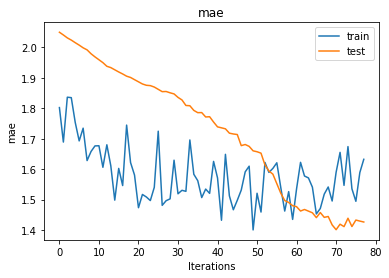

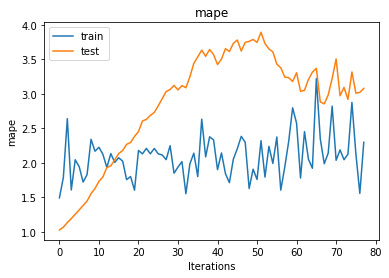

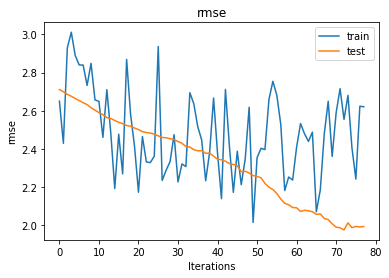

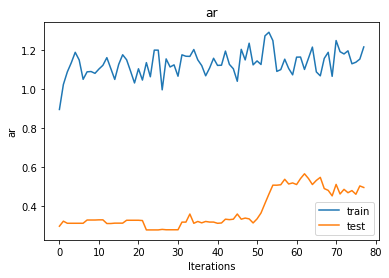

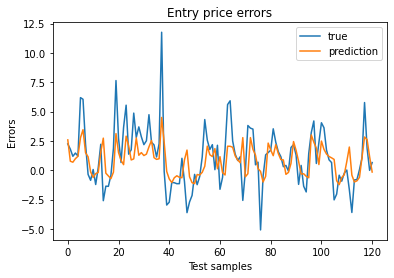

[MSE Baseline] train: 7.675605363351085  test: 5.120497475636996
1/1 [==============================] - 0s 38ms/step - loss: 3.9698 - mse: 3.9698 - mae: 1.4265 - mape: 3.0788 - rmse: 1.9924 - ar: 0.4936


In [22]:
data_name = data_names[0]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

lstm = make_LSTM_model()
history = lstm.fit(data_gen_train, validation_data=data_gen_test, epochs = EPOCHS,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], lstm)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[0] = lstm.evaluate(data_gen_test)

### Apple Stock

GAN-stock-entry/datasets/AAPL.csv
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 5, 10)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_3 (Ba

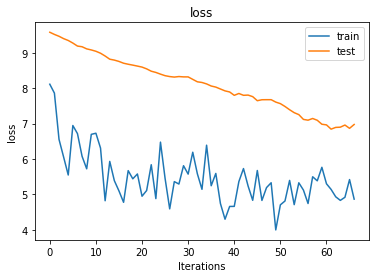

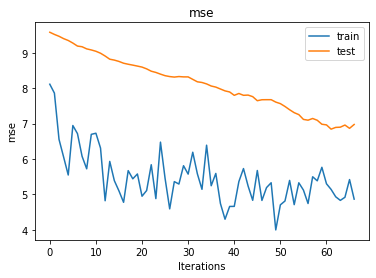

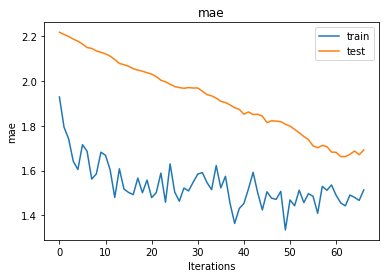

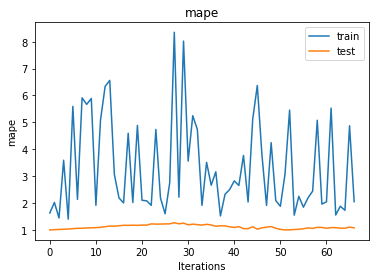

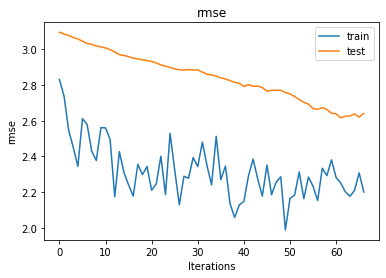

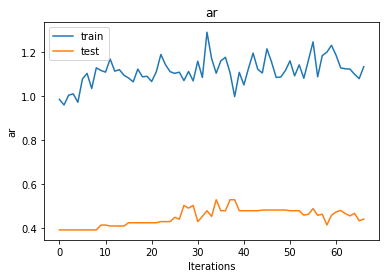

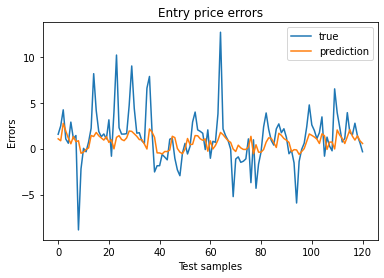

[MSE Baseline] train: 6.598211546763114  test: 7.507943742017361
1/1 [==============================] - 0s 31ms/step - loss: 6.9731 - mse: 6.9731 - mae: 1.6916 - mape: 1.0778 - rmse: 2.6407 - ar: 0.4398


In [23]:
data_name = data_names[1]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

lstm = make_LSTM_model()
history = lstm.fit(data_gen_train, validation_data=data_gen_test, epochs = EPOCHS, 
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], lstm)
print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
results[1] = lstm.evaluate(data_gen_test)

### Amazon Stock

GAN-stock-entry/datasets/AMZN.csv
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 5, 10)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_5 (Ba

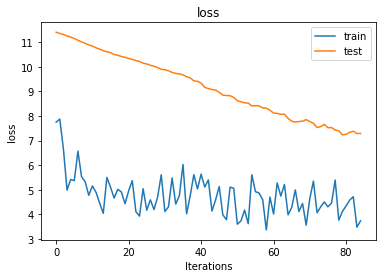

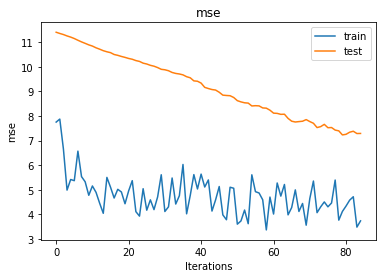

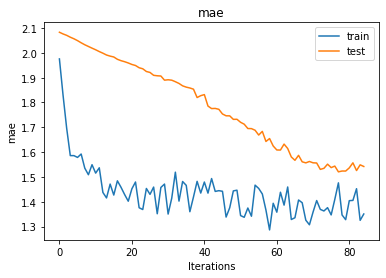

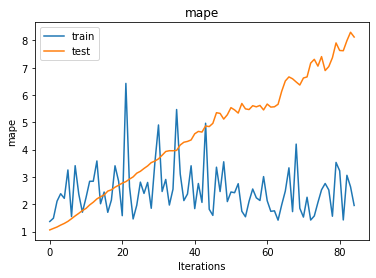

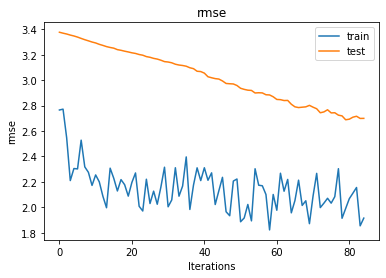

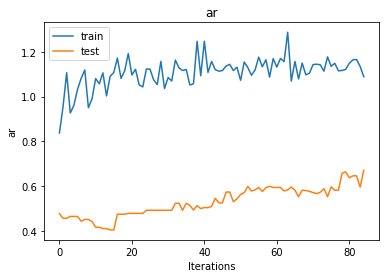

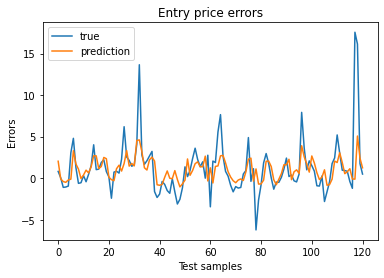

[MSE Baseline] train: 5.63983004336128  test: 9.576144001393743
1/1 [==============================] - 0s 33ms/step - loss: 7.2885 - mse: 7.2885 - mae: 1.5421 - mape: 8.1222 - rmse: 2.6997 - ar: 0.6706


In [24]:
data_name = data_names[2]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)


#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

lstm = make_LSTM_model()
history = lstm.fit(data_gen_train, validation_data=data_gen_test, epochs = EPOCHS, 
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], lstm)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[2] = lstm.evaluate(data_gen_test)

### Facebook Stock

GAN-stock-entry/datasets/FB.csv
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 5, 10)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_7 (Batc

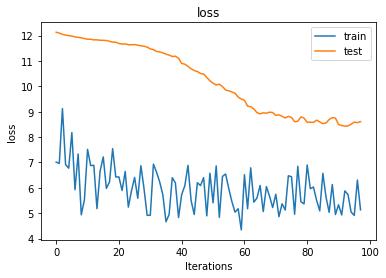

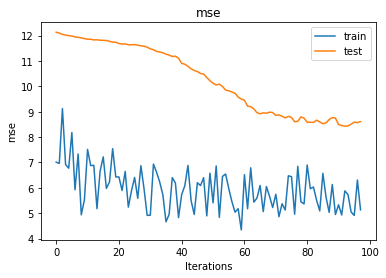

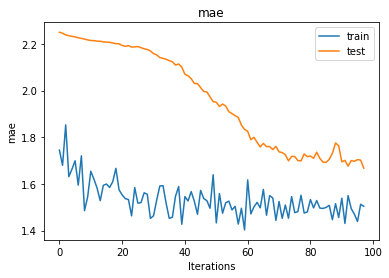

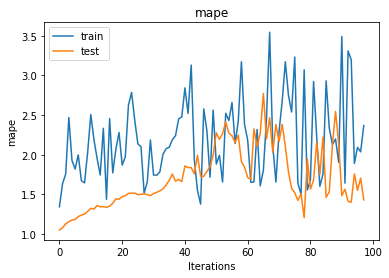

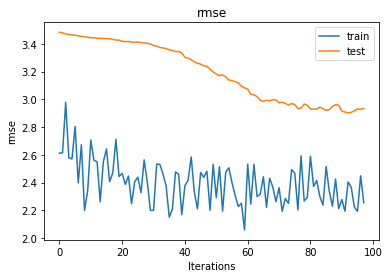

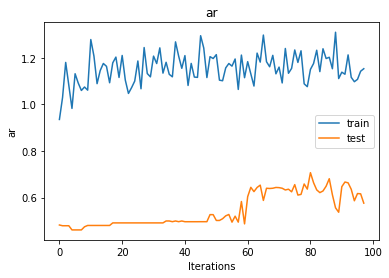

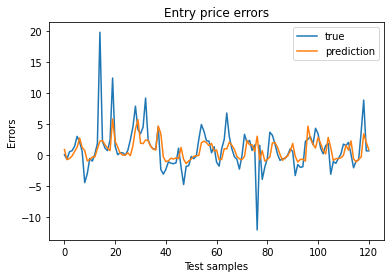

[MSE Baseline] train: 4.844341019728598  test: 9.57223803257757
1/1 [==============================] - 0s 42ms/step - loss: 8.6104 - mse: 8.6104 - mae: 1.6673 - mape: 1.4300 - rmse: 2.9343 - ar: 0.5759


In [25]:
data_name = data_names[3]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

lstm = make_LSTM_model()
history = lstm.fit(data_gen_train, validation_data=data_gen_test, epochs = EPOCHS, 
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], lstm)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[3] = lstm.evaluate(data_gen_test)

### Tesla Stock

GAN-stock-entry/datasets/TSLA.csv
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_9 (Ba

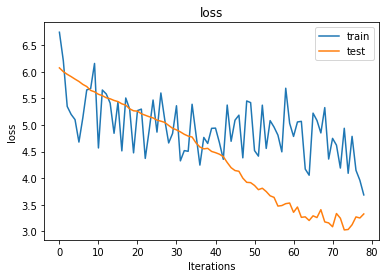

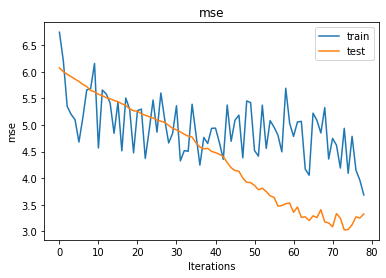

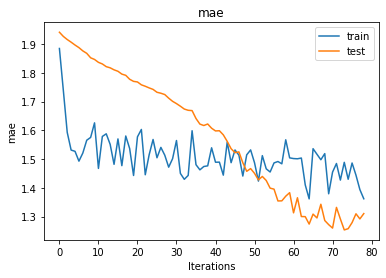

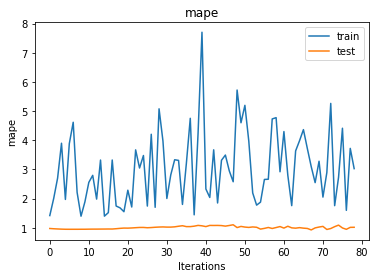

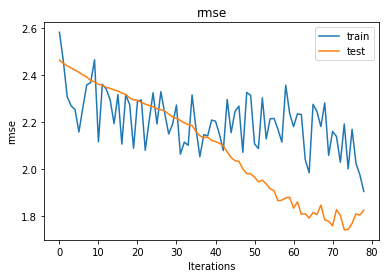

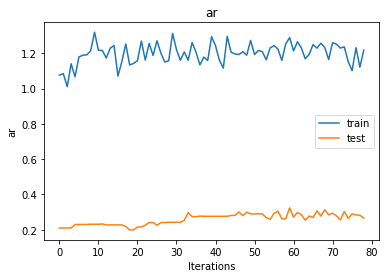

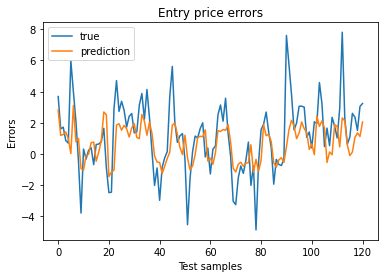

[MSE Baseline] train: 6.099606811490564  test: 4.047766210431176
1/1 [==============================] - 0s 39ms/step - loss: 3.3293 - mse: 3.3293 - mae: 1.3106 - mape: 1.0186 - rmse: 1.8246 - ar: 0.2664


In [26]:
data_name = data_names[4]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

lstm = make_LSTM_model()
history = lstm.fit(data_gen_train, validation_data=data_gen_test, epochs = EPOCHS, 
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], lstm)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[4] = lstm.evaluate(data_gen_test)

## Results

In [27]:
df = pd.DataFrame(data = results, index = data_names, columns = metrics)
df.loc['mean'] = results.mean(axis=0)
df

,loss,mse,mae,mape,rmse,ar
GOOG,3.969750,3.969750,1.426539,3.078760,1.992423,0.493558
AAPL,6.973061,6.973061,1.691649,1.077848,2.640655,0.439814
AMZN,7.288479,7.288479,1.542123,8.122208,2.699718,0.670596
FB,8.610387,8.610387,1.667282,1.430013,2.934346,0.575901
TSLA,3.329295,3.329295,1.310649,1.018566,1.824636,0.266392
mean,6.034194,6.034194,1.527648,2.945479,2.418356,0.489252
